# Exploring Steam Genres
Matthew Epland  
[phy.duke.edu/~mbe9](http://www.phy.duke.edu/~mbe9)

### Setup

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../graph_helper")
from graph_helper import *
import seaborn as sns
import community
import json
from random import sample
from visJS2jupyter import visJS_module

# For display purposes
%matplotlib inline

In [2]:
output_path = '../output'

edges_path = '../data/edges_merged.csv'
app_genres_path = '../data/app_genres.csv'
app_id_path = '../data/app_id.csv'

## Load Data

In [3]:
df_g = pd.read_csv(app_genres_path, dtype={'appid': int, 'Genre': object})

g_names_in = collections.defaultdict(list)
for index, row in df_g.iterrows():
    g_names_in[row['appid']].append(row['Genre'])
    
for k,v in g_names_manual.items():
    if k not in g_names_in.keys():
        g_names_in[k] = v

In [4]:
df_t = pd.read_csv(app_id_path, dtype={'appid': int, 'Title': object})

if len(df_t[df_t.duplicated(subset=['appid'], keep=False)].index) > 0:
    raise ValueError('Duplicate appid in df_t!')
    
df_t_index = df_t.set_index('appid')
df_t_names = df_t_index[['Title']]
t_names_in = df_t_names.to_dict()['Title']

for k,v in t_names_manual.items():
    t_names_in[k] = v

In [5]:
# merge nodes which have the same title
to_merge, t_names, g_names = clean_game_titles(t_names_in, g_names_in)

### Load edges, decide what minimum to keep

In [6]:
df_e_tmp= pd.read_csv(edges_path, dtype={'n1': int, 'n2': int, 'records':int})

count    2.421693e+06
mean     6.253337e+02
std      7.010269e+03
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      8.500000e+01
max      1.901259e+06
Name: records, dtype: float64

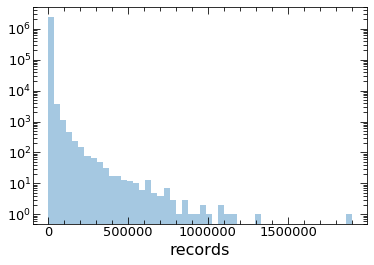

In [7]:
ax = sns.distplot(df_e_tmp['records'], kde=False, rug=False);
ax.set_yscale('log')
df_e_tmp['records'].describe()

count    4.181000e+03
mean     1.160789e+05
std      1.099868e+05
min      5.000200e+04
25%      6.143500e+04
50%      8.002500e+04
75%      1.236110e+05
max      1.901259e+06
Name: records, dtype: float64

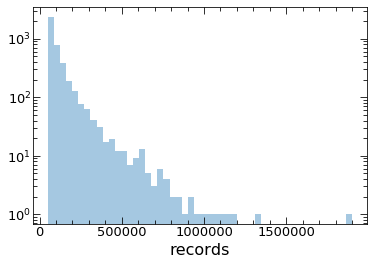

In [8]:
min_edge_weight = 50000

df_e = df_e_tmp.loc[df_e_tmp['records'] > min_edge_weight]
ax = sns.distplot(df_e['records'], kde=False, rug=False);
ax.set_yscale('log')
df_e['records'].describe()

### Build graph G
#### Construct G explicitly, edge by edge, so the weights are correct. Annotate nodes with the total weights from all their edges

In [9]:
G_tmp = build_G(df_e, return_total_weights=False)

In [10]:
# merge nodes which share the same title
G, total_weights, t_names, g_names = clean_game_titles_in_graph(G_tmp, to_merge, t_names, g_names)

### Find which nodes to keep

235 nodes


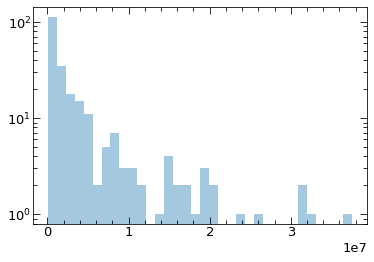

In [11]:
print('{0:d} nodes'.format(len(total_weights)))
ax = sns.distplot(total_weights, kde=False, rug=False);
ax.set_yscale('log')

In [12]:
# Just keep all for now
# G = G_tmp

In [13]:
# check to see if we're missing any needed metadata
missing_title = []
missing_genre = []
for node in G.nodes(data=True):
    n = node[0]
    if n not in t_names.keys():
        missing_title.append(n)
    if len(g_names[n]) == 0:
        missing_genre.append(n)
        
if len(missing_title) > 0:
    print('Missing title for appids:')
    for mt in sorted(missing_title):
        print("{0:d}:'',".format(mt))

if len(missing_genre) > 0:
    print('Missing genre for appids:')
    for mg in sorted(missing_genre):
        print("{0:d}:[''],".format(mg))

### Create node positions

In [14]:
# using the Fruchterman-Reingold force-directed / spring algorithm
# k=1/sqrt(n) is the default spring / spacing parameter
# Increase max iterations to 100, just in case it needs it
# Need to install networkx from master to access new random_state parameter
# Sets the random seed and allows for reproducable layouts across runs

# pos = nx.spring_layout(G, k=4/np.sqrt(nx.number_of_nodes(G)), iterations=100) #, random_state=5

# using the Kamada-Kawai path-length cost-function
pos = nx.kamada_kawai_layout(G)

# pos = nx.spectral_layout(G)
# pos = nx.circular_layout(G)

### Create communities using the Louvain Method

In [15]:
# The resolution parameter affects the size of the returned communities
# resolution=1 is the default unmodified Louvain Method
communities = community.best_partition(G, weight='weight', resolution=1)

nx.set_node_attributes(G, name='community', values=communities)
node_to_color = my_node_to_color(G,field_to_map='community')

In [16]:
# Setup useful G variables
nodes_all = G.nodes()

# nodes_to_shape = {}
# for n in nodes_all:
    # nodes_to_shape[n] = g_symbols[g_names[n]]
# nx.set_node_attributes(G, name='symbol', values=nodes_to_shape)

edge_to_color_all = my_edge_to_color(G)

In [17]:
# tmp just make everything a dot
nodes_to_shape = {}
for n in nodes_all:
    nodes_to_shape[n] = 'dot'
nx.set_node_attributes(G, name='symbol', values=nodes_to_shape)

## Plot static graphs

min edge weight != 1, edge color scale might be off...


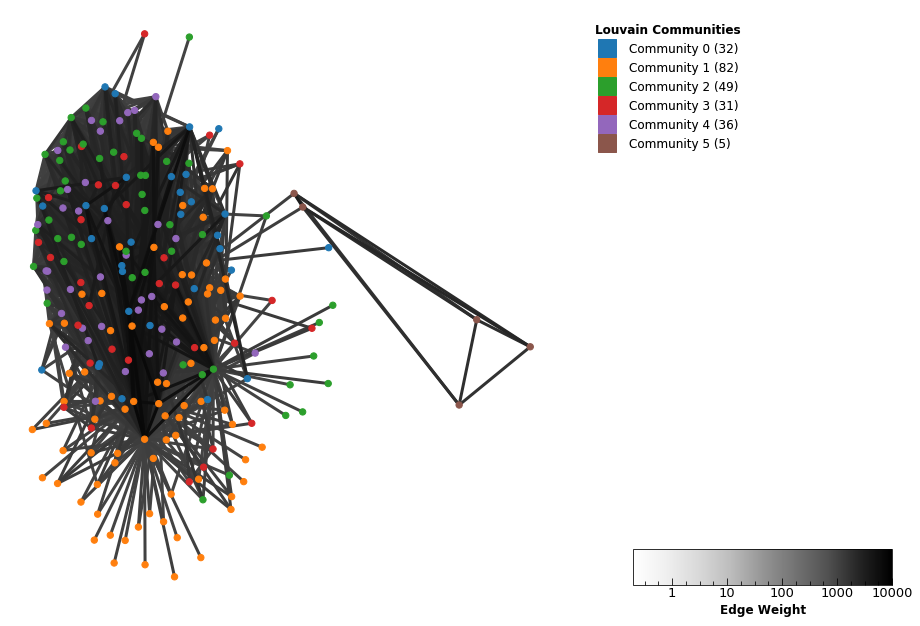

In [18]:
plot_graph(G, pos, output_path, skip_first_edge_bin=False, fname = 'graph', inline=True,
           edge_to_color_all=edge_to_color_all, node_to_color=node_to_color)

### Prune small communities (Not needed now...)

In [19]:
# G_pruned = prune_communities(G, min_size=16)
G_pruned = G

In [20]:
# plot_graph(G_pruned, pos, output_path, skip_first_edge_bin=False, fname = 'graph_pruned', inline=True)

### Describe Communities

In [21]:
community_info, community_genre_comp, all_used_genres = get_community_info(G_pruned, t_names, g_names)

In [22]:
# from graph_helper import *
write_community_info(community_info, output_path)

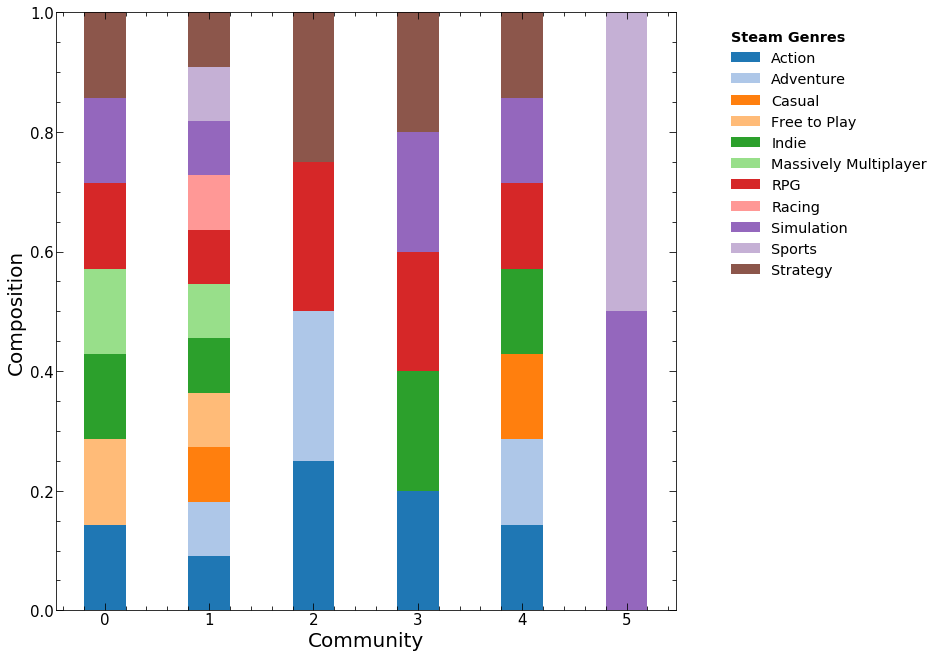

In [23]:
plot_community_genre_comp(community_genre_comp, all_used_genres, output_path, fname = 'genre_comps', inline=True)

## Make predictions and test them

In [24]:
predictions = make_predictions(G, top_k=5)

In [25]:
# print(predictions)

In [26]:
# drop any games we aren't making predictions on to save memory, actually run in bash / hdd since it won't fit in memory. Bit of a hack but it works...
look_up_dict = {}
for k,v in to_merge.items():
    for source in v[1:]:
        look_up_dict[source] = k

appids_to_keep = list(set(list(predictions.keys())+list(look_up_dict.keys())))
# print(sorted(appids_to_keep))

In [27]:
libs_path = '../data/all_players_trimmed_and_cut.csv'
df_libs = pd.read_csv(libs_path, usecols=[0,1], dtype={'steamid': int, 'appid': int}, engine='c')

In [28]:
steamids = list(df_libs['steamid'].unique())

In [29]:
n_steamids = len(steamids)
print('number of game records: {0}'.format(len(df_libs.index)))
print('number of unique steamids: {0}'.format(n_steamids))

number of game records: 256951632
number of unique steamids: 36854086


In [30]:
predictions_success_num = collections.defaultdict(int)
predictions_all_den = collections.defaultdict(int)

In [31]:
for i,steamid in enumerate(sample(steamids,1000)):
    if i % 250 == 0:
        print('On {0} of 1000'.format(i))
    appids = set(look_up_dict.get(appid, appid) for appid in df_libs.loc[df_libs['steamid']==steamid]['appid'].to_list()) # cleaned appids that this steamid owns
    for appid in appids:
        ncorrect = len(predictions[appid].intersection(appids)) # for appid, this is the number of predictions we got right, they own those predicted appids
        if ncorrect > 3:
            predictions_success_num[appid] += 1
        predictions_all_den[appid] += 1

On 0 of 1000
On 250 of 1000
On 500 of 1000
On 750 of 1000


In [32]:
predictions_acc = {}
for appid,success in predictions_success_num.items():
    predictions_acc[appid] = success / predictions_all_den[appid]

In [33]:
# with open('{0:s}/predictions_acc.json'.format(output_path), 'w') as f:
#     json.dump(predictions_acc, f, sort_keys=True, indent=2)

In [34]:
from graph_helper import *
plot_prediction_acc(predictions_acc, t_names, communities, node_to_color, output_path, fname = 'prediction_acc', acc_min=0.0, acc_max=1.0, label_xticks=False)
plot_prediction_acc(predictions_acc, t_names, communities, node_to_color, output_path, fname = 'prediction_acc_low', acc_min=0.0, acc_max=0.25, label_xticks=True)
plot_prediction_acc(predictions_acc, t_names, communities, node_to_color, output_path, fname = 'prediction_acc_high', acc_min=0.5, acc_max=1.0, label_xticks=True)

## Draw interactive graph

In [35]:
# create nodes_dict
nodes_pruned = G_pruned.nodes(data = False)
seperator = ', '
nodes_dict = [{"id":int(n),
               "title":("<center><b>{title:s}</b><br>Community {community:d}<br>Node Weight: {total_weight:.0f}<br>Genres: {genres:s}</center>".format(
                   title=t_names.get(n, 'MISSING'),
                   community=communities[n],
                   total_weight=G_pruned.node[n]['total_weight'],
                   genres=seperator.join(g_names[n]),
                   )),
               "x":pos[n][0]*1000,
               "y":(1-pos[n][1])*1000,
               "color":node_to_color[n],
               "node_shape":G_pruned.node[n]['symbol'],
               "node_size":G_pruned.node[n]['total_weight']
              } for n in nodes_pruned]
node_map = dict(zip(nodes_pruned,range(len(nodes_pruned)))) # map to indices for source/target in edges

In [36]:
# create edges_dict
edges_dict = [{"source":node_map[e[0]],
               "target":node_map[e[1]],
               "title":("<center>n1: {n1:s}<br>n2: {n2:s}<br>Edge Weight: {e_weight:.0f}</center".format(
                   n1=t_names.get(e[0], 'MISSING'),
                   n2=t_names.get(e[1], 'MISSING'),
                   e_weight=e[2]['weight']
               )),
               "color":edge_to_color_all.get((e[0],e[1]), edge_to_color_all.get((e[1],e[0]), None)),
              } for e in G_pruned.edges(data=True)]

In [37]:
nodes_dict[0];

In [38]:
# save the dicts for later viewing
with open('{0:s}/nodes.json'.format(output_path), 'w') as f:
    json.dump(nodes_dict, f, sort_keys=True, indent=2)

with open('{0:s}/edges.json'.format(output_path), 'w') as f:
    json.dump(edges_dict, f, sort_keys=True, indent=2)

In [ ]:
visJS_module.visjs_network(nodes_dict, edges_dict,
                           node_size_field='node_size', node_size_transform='Math.log', node_size_multiplier=2,
                           node_font_size=0,
                           edge_width=9, edge_title_field="title",
                           physics_enabled=False,
                           graph_title="Interactive Steam Graph",
                           graph_width = 940, graph_height = 600, border_color='black',
                           tooltip_delay = 0, graph_id = 0, config_enabled=False
                          )